In [1]:
import os
import math
import json
import gzip
import time
import calendar
from datetime import datetime
import numpy as np
import pandas as pd
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
SETS = './sets/' # папка с файлами с наборами

In [2]:
def default_serializer(obj): # для правильного преобразования даты в ISO формат
    if isinstance(obj, (date)):
        return obj.isoformat()
    raise TypeError(f'Object of type {obj.__class__.__name__} is not JSON serializable')
    

def load_dataset(filename): 
    if os.path.exists(SETS + filename + '.gz'):
        with gzip.open(SETS + filename + '.gz', 'rb') as gzip_ref:
            return pd.DataFrame(json.load(gzip_ref))
        
    
def save_dataset(filename):
    data = globals().get(filename)
    if data is not None:
        data = data.to_dict(orient='records')
        json_data = json.dumps(data, ensure_ascii=False, default=default_serializer)
        with gzip.open(SETS + filename + '.gz', 'wb') as gzip_file:
            gzip_file.write(json_data.encode('utf-8'))
        print(f'Сохранено {len(data)} записей в {filename}.gz')

In [3]:
pd.set_option('display.max_colwidth', None) # для отображения полного текста в ячейках
pd.set_option('display.max_columns', None) 
exams_stroi = load_dataset('exams_stroi')

In [4]:
exams_stroi['year'] = pd.to_datetime(exams_stroi['start']).dt.year
exams_stroi.head()

,global_id,start,end,near_stroi,stupid,year
0,797946035,2017-03-01T00:00:00,2017-09-30T00:00:00,0.415290,3.800000,2017
1,797949150,2017-03-01T00:00:00,2017-09-30T00:00:00,0.423029,3.357143,2017
2,797949275,2017-03-01T00:00:00,2017-09-30T00:00:00,0.059235,1.100000,2017
3,797949425,2017-03-01T00:00:00,2017-09-30T00:00:00,0.368473,6.600000,2017
4,797949570,2017-03-01T00:00:00,2017-09-30T00:00:00,0.358154,5.000000,2017


In [7]:
df = exams_stroi[['year', 'near_stroi', 'stupid']]
X = df[['year', 'near_stroi']]  # Признаки: год и near_stroi
y = df['stupid']  # Целевая переменная

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
model = LinearRegression()

In [10]:
model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = model.predict(X_test)

In [12]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [14]:
# Вывод метрик
print(f'Mean Squared Error: {mse:.2f}')
print(f'R²: {r2:.2f}')

Mean Squared Error: 2.61
R²: 0.01


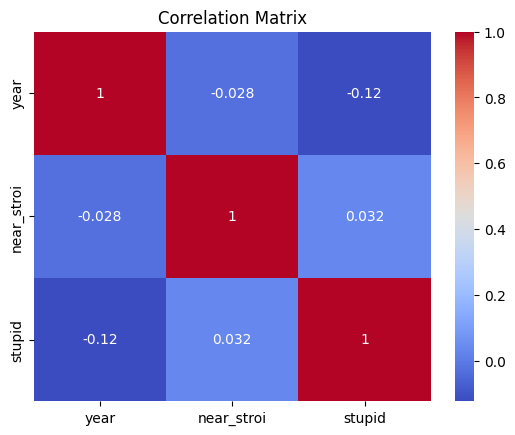

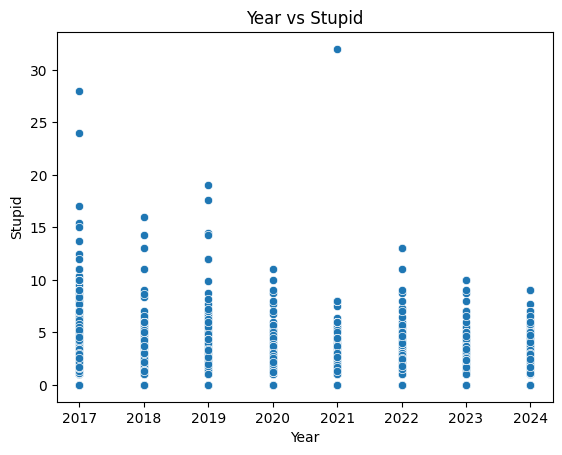

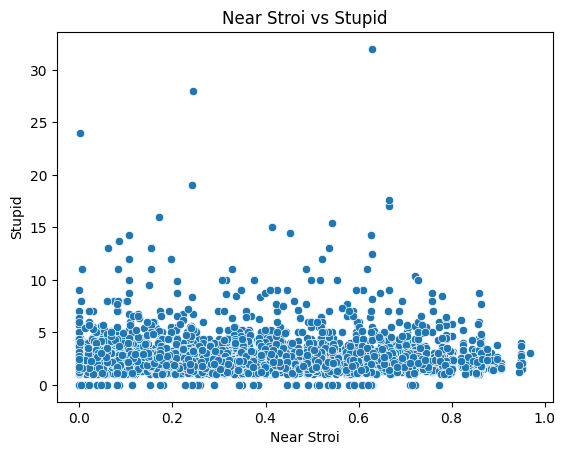

In [15]:
# Проверка корреляций
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

# Визуализация зависимости 'stupid' от 'year'
sns.scatterplot(data=df, x='year', y='stupid')
plt.title('Year vs Stupid')
plt.xlabel('Year')
plt.ylabel('Stupid')
plt.show()

# Визуализация зависимости 'stupid' от 'near_stroi'
sns.scatterplot(data=df, x='near_stroi', y='stupid')
plt.title('Near Stroi vs Stupid')
plt.xlabel('Near Stroi')
plt.ylabel('Stupid')
plt.show()